# Ensemble Learning
- Used for both classification and regression
- Aggregate the predictions of many individual predictors to achieve a better prediction accuracy. This is called the `wisdom of the crowd`
- Can combine many types of predictors from different algorithms
- Random Forest is one well-known algorithms where multiple Decision Tree predictors are used
- Hard voting: the class with the majority vote is selected as the prediction
- Soft voting: the class with the highest probability from individual predictors is used
<center><img src='../assets/ensemble_learning.png' width="600" height="800"></center>

Let's try out a simple Ensemble Model built up by multiple classification algorithms. The toy dataset is available with scikit-learn.

In [1]:
from utils import plot_decision_boundary, plot_2d_boundary, plot_dataset
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X_moon, y_moon = make_moons(n_samples=500, noise=0.30, random_state=42)
X_moon_train, X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon, y_moon, random_state=42)

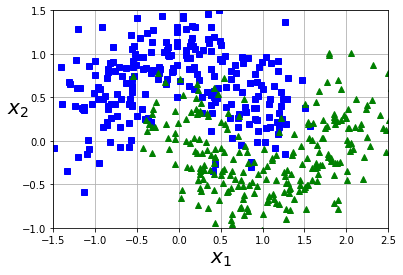

In [3]:
plot_dataset(X_moon, y_moon, [-1.5, 2.5, -1, 1.5])
plt.show()

In [4]:
#from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
#rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
tree_clf = DecisionTreeClassifier(max_depth= 3, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('tf', tree_clf), ('svc', svm_clf)],
    voting='hard')

In [5]:
voting_clf.fit(X_moon_train, y_moon_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('tf',
                              DecisionTreeClassifier(max_depth=3,
                                                     random_state=42)),
                             ('svc', SVC(random_state=42))])

In [6]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_moon_train, y_moon_train)
    y_moon_pred = clf.predict(X_moon_test)
    print(clf.__class__.__name__, accuracy_score(y_moon_test, y_moon_pred))

LogisticRegression 0.864
DecisionTreeClassifier 0.896
SVC 0.896
VotingClassifier 0.904


The VotingClassifier slightly outperforms the remaining classifier

One way to do ensemble learning is to train different classifiers using different algorithms. However we can have another approach that is to train using the same training algorithms but on different subsets of the training data. If we sample the subset with replacement, we have `bagging`. If we sample the subset of training data without replacement, we have `pasting` method. The key advantages of ensemble learning using `bagging` or `pasting` are that only only they have higher accuracy but they also can be computed in parallel in different processing units or on different servers.

Let's train an ensemble of `DecisionTreeClassifier` using `bagging` or `pasting` method.

In [7]:
from sklearn.ensemble import BaggingClassifier

bagging_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators=500,
        max_samples = 100, # each classifier trains on a subset of 100 training examples
        bootstrap=True,  # True for `bagging` and False for `pasting`
        n_jobs=-1, # use all CPU cores on your machine
        oob_score=True #automatically use instances that were not sampled for evaluation, give better estimation for test data
)


bagging_clf.fit(X_moon_train, y_moon_train)

# print this if using oob_score
#print('Accuracy of bagging classifier:', bagging_clf.oob_score_)
y_moon_pred = bagging_clf.predict(X_moon_test)
print(accuracy_score(y_moon_test, y_moon_pred))

0.92


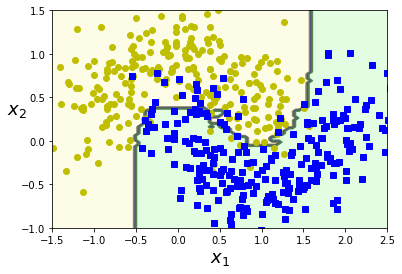

In [8]:
plot_decision_boundary(bagging_clf, X_moon, y_moon, [-1.5, 2.5, -1.0, 1.5],iris=False)

What we've done is actually called RandomForest algorithm, which is simply the ensemble of DecisionTreeClassifier. Here is another way to do it in scikit-learn.

In [9]:
from sklearn.ensemble import RandomForestClassifier

random_forest_clf = RandomForestClassifier(n_estimators=500, max_depth=5, n_jobs=-1)
random_forest_clf.fit(X_moon_train, y_moon_train)
    
y_moon_pred = random_forest_clf.predict(X_moon_test)

print(accuracy_score(y_moon_test, y_moon_pred))

0.92


#### Exercise ####
- Try to play around with the number of estimators and observe the decision boundary
- RandomForest actually also measures the feature's importance when perform training. As a  result, we can look at this and see which feature was useful for the decision tree to classify the target. We can access these scores via the `feature_importances_ attribute of the `random_forest_clf`

In [10]:
for name, score in zip(['X1', 'X2'], random_forest_clf.feature_importances_):
    print(name, score)

X1 0.40770717246324906
X2 0.5922928275367508


#### Apply an Ensemble Model on the Titanic dataset

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
final_train = pd.read_csv('../data/final_titanic_train.csv')

# create X (features) and y (response)
X_titanic = final_train.loc[:, ~final_train.columns.isin(['Survived'])]
y_titanic = final_train['Survived']

# use train/test split with different random_state values
# we can change the random_state values that changes the accuracy scores
# the scores change a lot, this is why testing scores is a high-variance estimate
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.2, random_state=2)

In [12]:
# Try a simple decision tree classifier

log_clf = LogisticRegression(solver="lbfgs", max_iter=5000, random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
tree_clf = DecisionTreeClassifier(max_depth= 5, random_state=42)


voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')



voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=5000,
                                                 random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [13]:
voting_clf.score(X_train,y_train)

0.875

In [14]:
# Perform cross validation score to validate the accuracy of the training
cross_val_score(VotingClassifier(
                    estimators=[('lr', log_clf), ('rf', rnd_clf), ('tree', tree_clf)],
                    voting='hard'),
                X_titanic, y_titanic, cv=10).mean()

0.8182272159800249

In [15]:
# Use random forest on our Titanic data and then look at its feature importance scores

random_forest_clf = RandomForestClassifier(n_estimators=250, max_leaf_nodes=60, min_samples_leaf=2 ,n_jobs=-1)
random_forest_clf.fit(X_train, y_train)
    
y_pred = random_forest_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.776536312849162


In [16]:
for name, score in zip(X_titanic.columns, random_forest_clf.feature_importances_):
    print(name, score)

Age 0.19902313911291908
Fare 0.2580260886654589
TravelAlone 0.03083521780270814
Pclass_2 0.02167448701936176
Pclass_3 0.09678252435393678
Embarked_Q 0.012776691537406914
Embarked_S 0.0276034059185007
Sex_male 0.3532784455897076
